In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyod

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 2.1MB 8.1MB/s 
  Created wheel for pyod: filename=pyod-0.7.8.2-cp36-none-any.whl size=104997 sha256=8b5cac11c642742e2dd1e61cab465a2900ed8f4e76869d56ff9d4423fcce9445
  Stored in directory: /root/.cache/pip/wheels/28/38/ec/0ecbcd67faeb595ac0dbd9b5f85d5c5bdcb4573819e65240fe
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=eb303255aac98da98daa72e145fffdae54219a85b27ad023b48d29f7ba063787
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=29ec609d7c585dd954c8912444f120beff8ffd8df429df899cb80912e90a146e
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [3]:
!pip install suod 

In [4]:
%cd /content/drive/My\ Drive/TAA

/content/drive/My Drive/TAA


In [0]:
import scipy.io
mat = scipy.io.loadmat('satimage-2.mat')

In [0]:
X, y = mat['X'], mat['y']

In [0]:
y[y == 1] = -1
y[y == 0] = 1

In [8]:
from sklearn.svm import OneClassSVM
import time
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def evaluation_detection(ytrue,ypred):
  x1 = X_test[:,10]
  x2 = X_test[:,20]

  fig = plt.figure(figsize=(10,14))

  ax0 = fig.add_subplot(5,2,1)
  ax0.scatter(x1, x2, alpha=0.7, c=ytrue)
  ax0.set_title('Représentation des données selon le vrai label')
  ax0.set_xlabel('x1') 
  ax0.set_xlabel('x2') 

  ax1 = fig.add_subplot(5,2,2)
  colors = np.array(['#377eb8', '#ff7f00']) 
  ax1.scatter(x1, x2, alpha=0.5,  c=colors[(ypred + 1) // 2])
  ax1.set_title('Représentation des données selon le label prédit')
  ax1.set_ylabel('x1')
  ax1.set_ylabel('x2')

  ax2 = fig.add_subplot(5,2,3)
  data = confusion_matrix(ytrue, ypred)
  labels = ['Outlier', 'Inliers']
  sns.heatmap(data, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", ax=ax2) 
  ax2.set_title('Matrice de confusion')

  plt.tight_layout()
  plt.show()

In [0]:
#outlier_prop = len(y[y==-1])/len(y) #0.012
outlier_prop = 0.025

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]

---------Robust covariance-----------


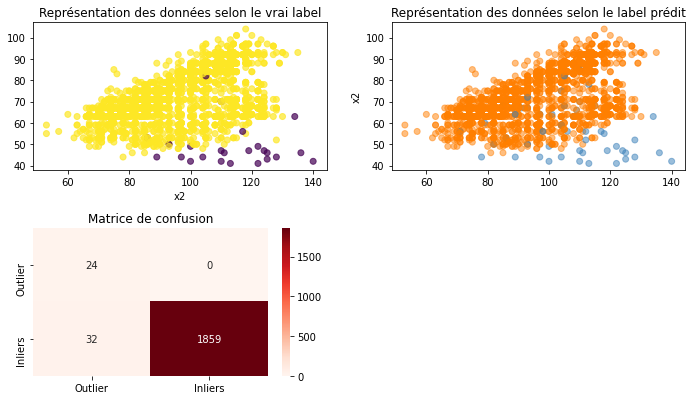

---------One-Class SVM-----------


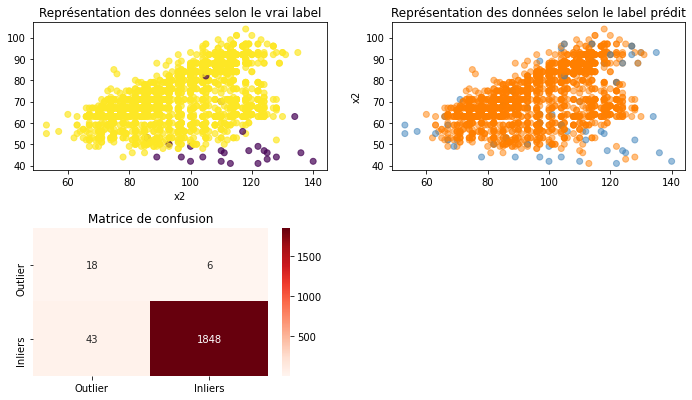

---------Isolation Forest-----------


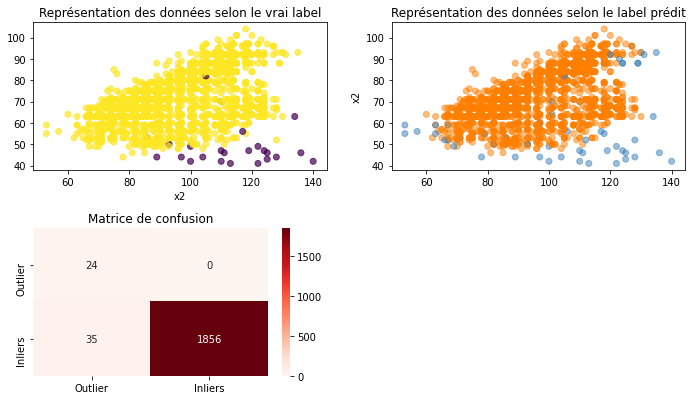

---------KNN-----------


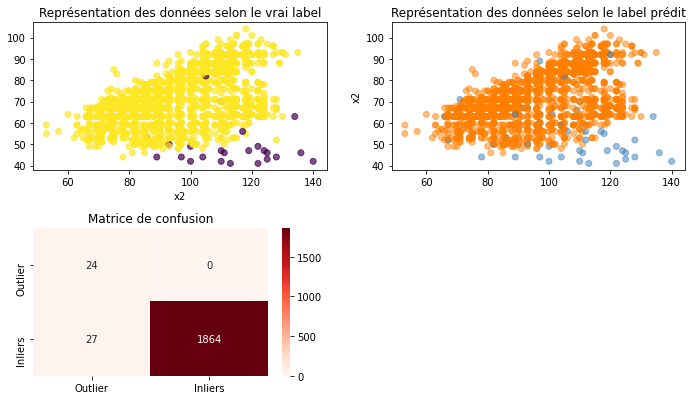

---------Local Outlier Factor-----------


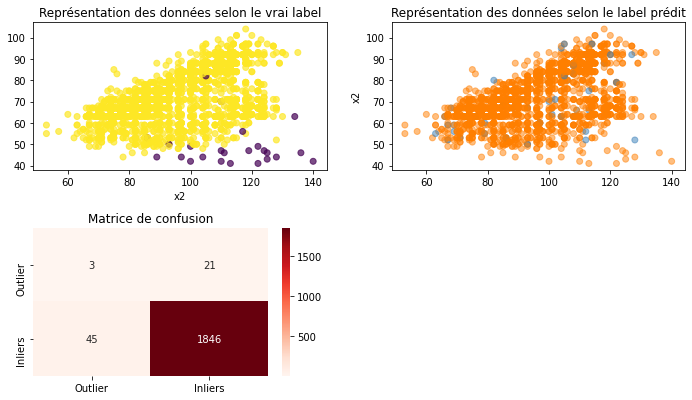

In [107]:
 for name, algorithm in anomaly_algorithms:
   algorithm.fit(X_train)
   if name == "KNN":
     y_pred = algorithm.predict(X_test)
   if name == "Local Outlier Factor":
     y_pred = algorithm.fit_predict(X_test)
   else:
     y_pred = algorithm.predict(X_test)
   if name == "KNN":
     y_pred[y_pred == 1] = -1
     y_pred[y_pred == 0] = 1
     print('---------'+name+'-----------')
     evaluation_detection(y_test,y_pred)
   else:
     print('---------'+name+'-----------')
     evaluation_detection(y_test,y_pred)